In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

from time import time

import multinet

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import cropset
import dataset

import matplotlib.pyplot as plt

In [3]:
net = multinet.pretrained("./model_multinet.pt")
backbone = net.features
# backbone.out_channels = net.classifier[1].in_features
backbone.out_channels = 20
num_classes = net.classifier[-1].out_features

anchor_generator = AnchorGenerator(
    sizes=((10,30,40,),), aspect_ratios=((1.,.5,),))
    
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'], output_size=15, sampling_ratio=1)

"""
image_mean (Tuple[float, float, float]): mean values used for input normalization.
  They are generally the mean values of the dataset on which the backbone has been trained
  on
image_std (Tuple[float, float, float]): std values used for input normalization.
  They are generally the std values of the dataset on which the backbone has been trained on
"""

# therefore should probably train features with z-score standardized data and provide mena and std into FasterRCNN
#  https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L61-L65

mean = (.4016, .3075, .2541)
std = (.3068, .2605, .2465)

model = FasterRCNN(
  backbone, num_classes=num_classes, image_mean=mean, image_std=std, min_size=800, max_size=800,
  rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)



# pretrained convnet features but classifier is not taken from pretrained model

net, model

loaded module has 5 classes


(MultiNet(
   (features): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=3920, out_features=2600, bias=True)
     (2): ReLU(inplace=True)
     (3): Linear(in_features=2600, out_features=1000, bias=True)
     (4): ReLU(inplace=True)
     (5): Linear(in_features=1000, out_features=5, bias=True)
   )
 ),
 FasterRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=(0.4016, 0.3075, 0.2541), std=(0.3068, 0.2605, 0.2465))
       Resize(min_size=(800,), max_size=800, mode='bilinear')
   )
   (backbone): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=

In [4]:
torch.__version__, torchvision.__version__

('1.9.0', '0.10.0')

In [5]:
dl = cropset.load(cropset.CropSet())
len(dl.dataset)

mean,std from train set: (0.4016, 0.3075, 0.2541) (0.3068, 0.2605, 0.2465)
mean,std from capture set: tensor([0.2945, 0.2550, 0.2586]) tensor([0.2492, 0.2100, 0.2303])


120

In [6]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=.005, momentum=0.9, weight_decay=0.0005)

STEP = 2

mlosses, maccs = [], []
for epoch in range(22):
  r_loss, r_acc = 0., 0.
  s = time()
  for i, (img, l) in enumerate(dl):
    model.train()
    loss_dict = model(img, l)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    r_loss += losses
    r_acc += 0  # dunno
    
    log = False
    if (i+1) % STEP == 0:
      divisor = STEP
      log = True
    elif i+1 == len(dl):
      divisor = (i+1) % STEP
      log = True
    if log:
      mlosses.append(r_loss/divisor)
      maccs.append(r_acc/divisor)
      print(f"epoch:{epoch+1} loss:{mlosses[-1]:.4f} acc:{maccs[-1]:.2f} took:{time()-s:.2f}")
      s = time()
      r_loss, r_acc = 0., 0.


/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:1 loss:2.4719 acc:0.00 took:4.66
epoch:1 loss:2.5404 acc:0.00 took:4.54
epoch:1 loss:2.5103 acc:0.00 took:6.17
epoch:1 loss:2.4370 acc:0.00 took:6.95
epoch:1 loss:2.3619 acc:0.00 took:4.31
epoch:1 loss:2.2839 acc:0.00 took:4.62
epoch:1 loss:2.2505 acc:0.00 took:5.32
epoch:1 loss:2.0854 acc:0.00 took:5.16
epoch:1 loss:1.9493 acc:0.00 took:4.38
epoch:1 loss:1.8883 acc:0.00 took:4.64
epoch:1 loss:1.7436 acc:0.00 took:5.03
epoch:1 loss:1.5706 acc:0.00 took:4.75
epoch:1 loss:1.2809 acc:0.00 took:4.24
epoch:1 loss:1.2694 acc:0.00 took:4.11
epoch:1 loss:1.2837 acc:0.00 took:4.08
epoch:2 loss:1.2690 acc:0.00 took:4.27
epoch:2 loss:1.4502 acc:0.00 took:4.73
epoch:2 loss:1.3888 acc:0.00 took:4.44
epoch:2 loss:1.3435 acc:0.00 took:4.17
epoch:2 loss:1.2267 acc:0.00 took:5.92
epoch:2 loss:1.3142 acc:0.00 took:5.64
epoch:2 loss:1.2056 acc:0.00 took:5.13
epoch:2 loss:1.2931 acc:0.00 took:4.92
epoch:2 loss:1.1946 acc:0.00 took:4.60
epoch:2 loss:1.1669 acc:0.00 took:6.19
epoch:2 loss:1.2947 acc:0

epoch:14 loss:0.5524 acc:0.00 took:4.37
epoch:15 loss:0.5074 acc:0.00 took:4.34
epoch:15 loss:0.5589 acc:0.00 took:4.54
epoch:15 loss:0.5296 acc:0.00 took:4.20
epoch:15 loss:0.5346 acc:0.00 took:4.11
epoch:15 loss:0.6190 acc:0.00 took:4.30
epoch:15 loss:0.4668 acc:0.00 took:4.48
epoch:15 loss:0.5562 acc:0.00 took:5.02
epoch:15 loss:0.4715 acc:0.00 took:4.90
epoch:15 loss:0.5416 acc:0.00 took:6.22
epoch:15 loss:0.5525 acc:0.00 took:4.62
epoch:15 loss:0.5685 acc:0.00 took:4.41
epoch:15 loss:0.4604 acc:0.00 took:4.56
epoch:15 loss:0.3904 acc:0.00 took:4.41
epoch:15 loss:0.5367 acc:0.00 took:4.06
epoch:15 loss:0.4645 acc:0.00 took:4.51
epoch:16 loss:0.5066 acc:0.00 took:4.59
epoch:16 loss:0.4732 acc:0.00 took:4.74
epoch:16 loss:0.5459 acc:0.00 took:4.92
epoch:16 loss:0.4823 acc:0.00 took:4.91
epoch:16 loss:0.4219 acc:0.00 took:5.06
epoch:16 loss:0.4485 acc:0.00 took:6.74
epoch:16 loss:0.5029 acc:0.00 took:4.45
epoch:16 loss:0.6083 acc:0.00 took:7.75
epoch:16 loss:0.4711 acc:0.00 took:4.92


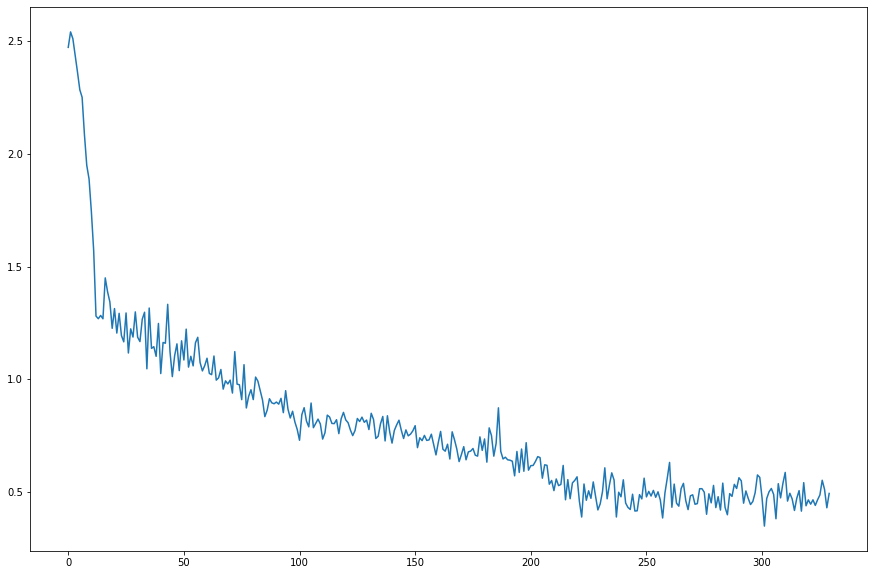

In [7]:
plt.figure(figsize=(15,10))
ax = plt.plot([i.detach().item() for i in mlosses])
plt.show()


torch.Size([3, 640, 800])
tensor([0.9550, 0.9472, 0.9256, 0.9193, 0.9035, 0.9033, 0.8799, 0.8790, 0.8639,
        0.1118])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False])


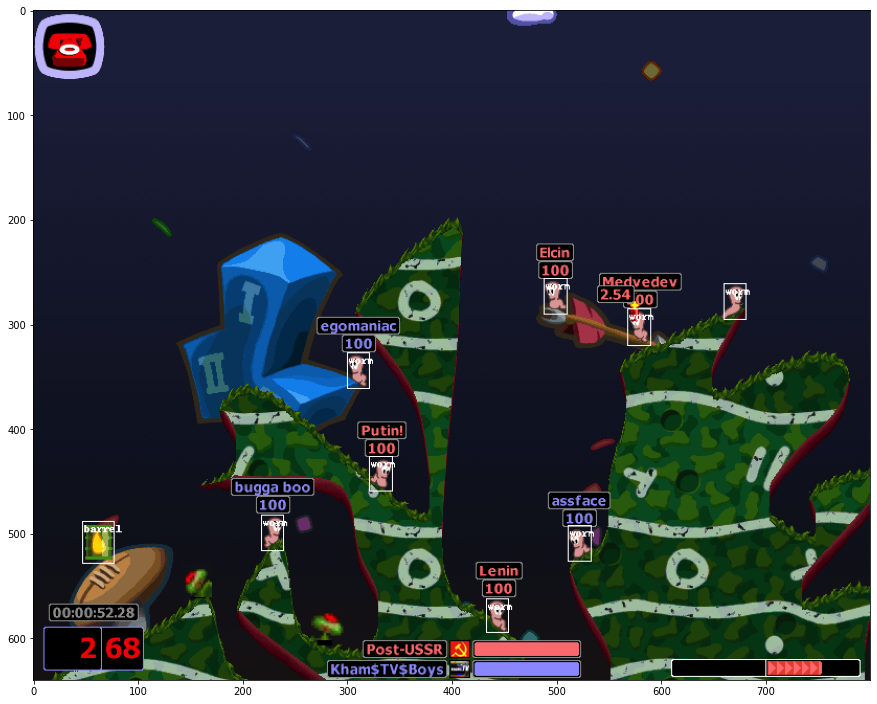

['bg', 'worm', 'mine', 'barrel', 'dynamite']

In [12]:
with torch.no_grad():
#   mean, std = (.4016, .3075, .2541), (.3068, .2605, .2465)  # from feature trainset
  mean, std = (0.2945, 0.2550, 0.2586), (0.2492, 0.2100, 0.2303)  # from capture set
#   transform = Compose([ToTensor(), Normalize(mean=mean, std=std)])
  transform = Compose([ToTensor()])
  img = transform(Image.open("/Users/lair/Desktop/2378_0_22947.png").convert('RGB'))
  print(img.shape)
  model.eval()
  y = model(img.unsqueeze(0))[0]
  print(y['scores'])

topk  = y['scores'] > .8
print(topk)
plt.figure(figsize=(15,15))
bb = draw_bounding_boxes(
  (img*255).to(torch.uint8), boxes=y['boxes'][topk], labels=[dataset.CLASSES[i] for i in y['labels'][topk]])
# bb = draw_bounding_boxes(
#   (img*255).to(torch.uint8), boxes=y['boxes'], labels=[dataset.CLASSES[i] for i in y['labels']])
plt.imshow(bb.permute(1,2,0))
plt.show()
dataset.CLASSES

In [9]:
models.detection.fasterrcnn_resnet50_fpn()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [10]:
models.mobilenet_v2()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen